# Variational Autoencoder (VAE)

In [4]:
import math
import numpy as np
from gymnasium.utils import seeding
import matplotlib.pyplot as plt
import cv2

CHECKPOINTS = 12
SCALE       = 6.0
TRACK_RAD   = 900/SCALE
TRACK_TURN_RATE = 0.31
TRACK_DETAIL_STEP = 21/SCALE
PLAYFIELD   = 2000/SCALE # Game over boundary

IMG_SIZE = 64  # Pixels

np_random, seed = seeding.np_random(None)

In [5]:
from gym_multi_car_racing import bezier

def get_track(control_points=None, np_random=np_random):
    if control_points is not None:
        a = np.array(control_points)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)
    else:
        a = bezier.get_random_points(n=12, scale=PLAYFIELD, mindst=None, np_random=np_random)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.2, numpoints=40)

    return a, x, y

In [6]:
def plot_track(track, checkpoints=None):
    # Plot track
    plt.plot(track[:,1], track[:,0], linewidth=9, color=[0.4, 0.4, 0.4])
    plt.plot([track[0,1], track[-1,1]], [track[0,0], track[-1,0]], linewidth=9, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            y, x = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)

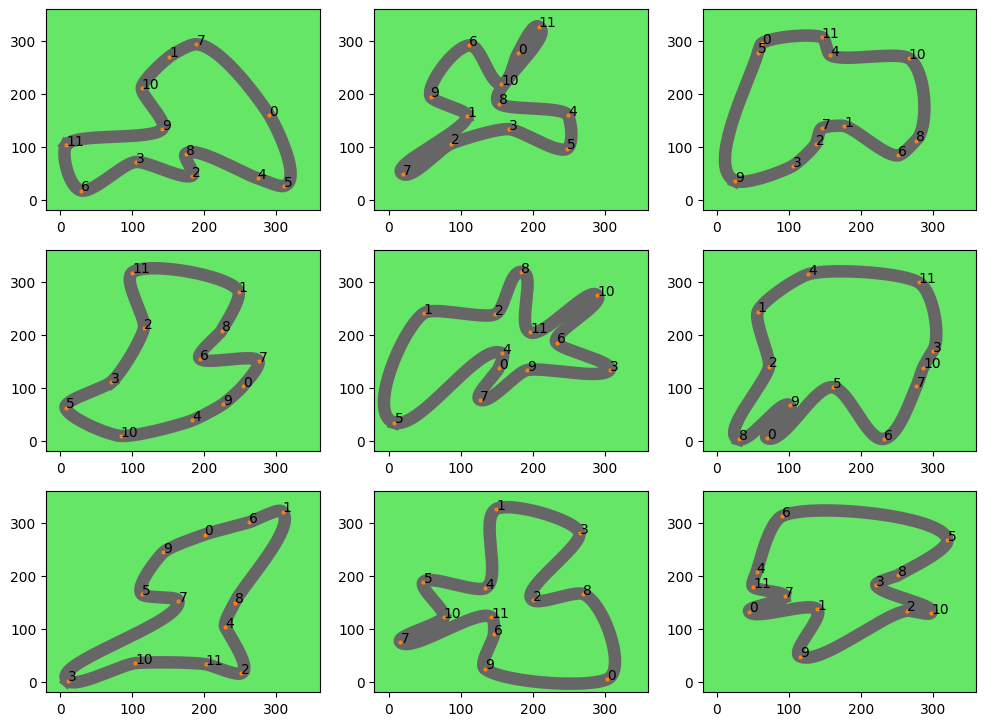

In [7]:
import matplotlib.pyplot as plt

num_plots = 9

width = 12 if num_plots > 3 else 4*num_plots
height = np.ceil(num_plots/3).astype(int)*4

plt.figure(figsize=(width, height))

for i in range(num_plots):

    plt.subplot(height//3, 3, i+1)

    checkpoints, x, y = get_track(np_random=np_random)
    track = np.array([x, y]).T

    # Plot track & checkpoints
    plot_track(track, checkpoints)

## Generate tracks

In [8]:
import cv2

# Create 2d image from track coordinates
def get_image(track, width=48, height=48):
    # Create image
    img = np.zeros((380, 380))
    
    # Shift image so it does not touch the boundary
    min_x = np.min(track[:,0])
    min_y = np.min(track[:,1])
    if min_x < 0:
        track[:,0] += -2*min_x
    if min_y < 0:
        track[:,1] += -2*min_y
    track = np.clip(track, 0, 380-1)
    
    for i in range(len(track)):
        x = track[i,0].astype(int)
        y = track[i,1].astype(int)
        img[x, y] = 1
    # Resize image
    img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
    img = np.ceil(img/2).astype(int)
    # Rotate image
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    return img

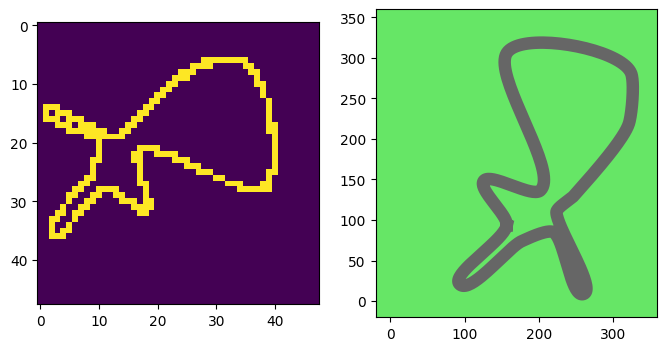

In [15]:
# Generate random track
checkpoints, x, y = get_track(np_random=np_random)
track = np.array([x, y]).T

# Get image from track
img = get_image(track)

# Plot track & image
plt.figure(figsize=(8,4))

# Plot image
plt.subplot(121)
plt.imshow(img)

# Plot track
plt.subplot(122)
plot_track(track)

In [16]:
num_tracks = 1_000

X = []  # Track images
Y = []  # x,y coordinates of track

for i in range(num_tracks):
    # Generate random track
    checkpoints, x, y = get_track(np_random=np_random)
    # Get image from track
    X.append(get_image(np.array([x, y]).T, width=IMG_SIZE, height=IMG_SIZE))
    Y.append([x,y])

X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.float32)
# Move axis
Y = np.moveaxis(Y, 1, 2)

X.shape, Y.shape

((1000, 64, 64), (1000, 480, 2))

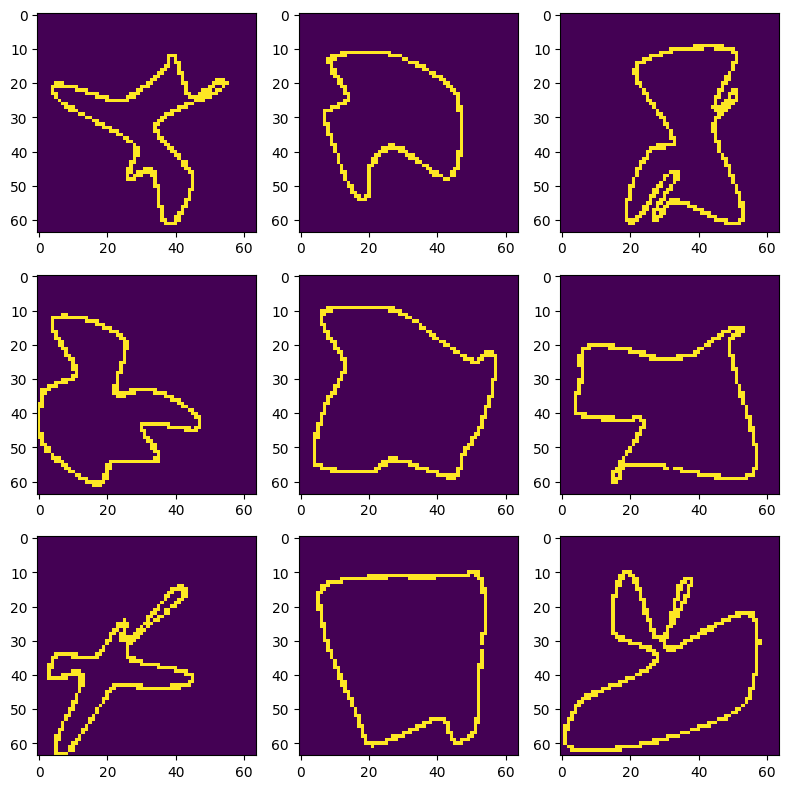

In [18]:
plt.figure(figsize=(8,8))
for i in range(9):
    j = np.random.randint(0, X.shape[0])
    plt.subplot(3,3,i+1)
    plt.imshow(X[j])
    #plt.axis('off')
plt.tight_layout()

Create dataset

In [19]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class TracksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, tracks, checkpoints=None):
        self.tracks = tracks
        self.checkpoints = checkpoints

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, index):
        x = TF.to_tensor(self.tracks[index])
        if self.checkpoints is not None:
            y = TF.to_tensor(self.checkpoints[index])
        else:
            y = None
        return x, y

In [20]:
X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)
dataset = TracksDataset(X, Y)

## Train VAE

In [25]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [27]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [28]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [29]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

def train(vae, data, epochs=50, bs=32):
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)
            recon_x, mu, logvar = vae(x)
            loss, bce, kld = loss_fn(recon_x, x, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                    epochs, loss.data.item()/bs, bce.data.item()/bs, kld.data.item()/bs)
            print(to_print, end="\r")
        print()

In [16]:
vae = VAE(z_dim=24).to(device) # GPU

data = DataLoader(dataset, batch_size=32, shuffle=True)

train(vae, data, epochs=300)

/home/zapata/.local/share/virtualenvs/curriculum_learning_ws-qGcE4JgX/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/300] Loss: 431.152 430.953 0.20091
Epoch[2/300] Loss: 306.682 305.900 0.782
Epoch[3/300] Loss: 260.784 260.032 0.752
Epoch[4/300] Loss: 263.579 262.919 0.660
Epoch[5/300] Loss: 260.120 259.493 0.628
Epoch[6/300] Loss: 242.486 241.785 0.700
Epoch[7/300] Loss: 215.853 215.204 0.649
Epoch[8/300] Loss: 240.477 239.811 0.666
Epoch[9/300] Loss: 228.855 228.183 0.673
Epoch[10/300] Loss: 225.657 224.967 0.690
Epoch[11/300] Loss: 214.910 214.281 0.629
Epoch[12/300] Loss: 211.534 210.906 0.628
Epoch[13/300] Loss: 217.499 216.887 0.612
Epoch[14/300] Loss: 224.086 223.437 0.648
Epoch[15/300] Loss: 210.055 209.466 0.589
Epoch[16/300] Loss: 197.480 196.879 0.600
Epoch[17/300] Loss: 191.407 190.826 0.581
Epoch[18/300] Loss: 203.746 203.235 0.512
Epoch[19/300] Loss: 186.967 186.413 0.554
Epoch[20/300] Loss: 194.233 193.670 0.563
Epoch[21/300] Loss: 185.440 184.849 0.591
Epoch[22/300] Loss: 190.422 189.888 0.534
Epoch[23/300] Loss: 189.550 188.996 0.555
Epoch[24/300] Loss: 181.837 181.287 0.550

In [17]:
# Save VAE model
torch.save(vae.state_dict(), f"vae_{IMG_SIZE}x{IMG_SIZE}_24.pt")

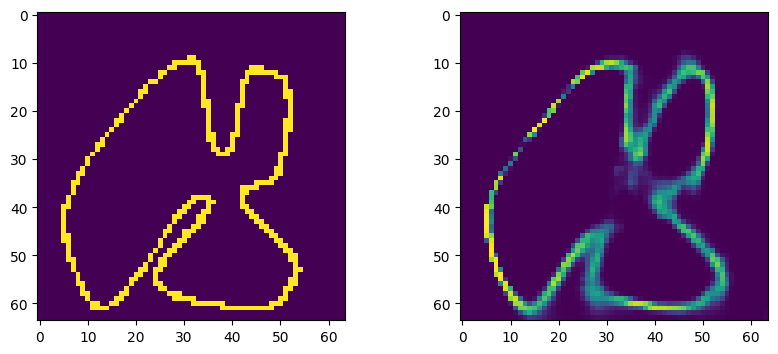

In [31]:
# Plot reconstruction
plt.figure(figsize=(10,4))

j = np.random.randint(0, X.shape[0])
x = dataset[j][0].unsqueeze(0).to(device)
recon_x, _, _ = vae(x)
recon_x = recon_x.to('cpu').detach().numpy().squeeze()

plt.subplot(121)
plt.imshow(x.cpu().squeeze())

plt.subplot(122)
plt.imshow(recon_x)

## Convert images to track coordinates

In [17]:
import alphashape

def get_control_points_from_image(img):
    """Image must have uint8 values from 0 to 255"""
    
    # Sharpen image
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    img = cv2.filter2D(img, -1, kernel)
    img = np.where(img < 30, 0, img)

    y, x = np.where(img != 0)
    # Calculate center
    center = [int(x.mean()), int(y.mean())]
    points_2d = np.array([x,y]).T
    # Fill contour
    for point in points_2d:
        cv2.line(img, point, center, color=255, thickness=1)
    points_2d = np.array(np.where(img > 100)).T
    # Get alpha shape
    alpha_shape = alphashape.alphashape(points_2d, alpha=0.6)
    geom_type = alpha_shape.geom_type
    alpha = 0.6
    while geom_type == "MultiPolygon":
        alpha -= 0.01
        alpha_shape = alphashape.alphashape(points_2d, alpha=alpha)
        geom_type = alpha_shape.geom_type

    points = np.array([xy for xy in alpha_shape.exterior.coords])
    points = fit_spline(points, num_points=300)

    return points*350/IMG_SIZE


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

def fit_spline(points, num_points=200):
    # Linear length along the line:
    distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
    distance = np.insert(distance, 0, 0)/distance[-1]

    # Build a list of the spline function, one for each dimension:
    splines = [UnivariateSpline(distance, coords, k=5, s=10) for coords in points.T]

    # Computed the spline for the asked distances:
    alpha = np.linspace(0, 1, num_points)
    points_fitted = np.vstack([spl(alpha) for spl in splines]).T

    return points_fitted

#### Reconstruct images using variational autoencoder (VAE)

Reconstruct randomly sampled vector from latent space

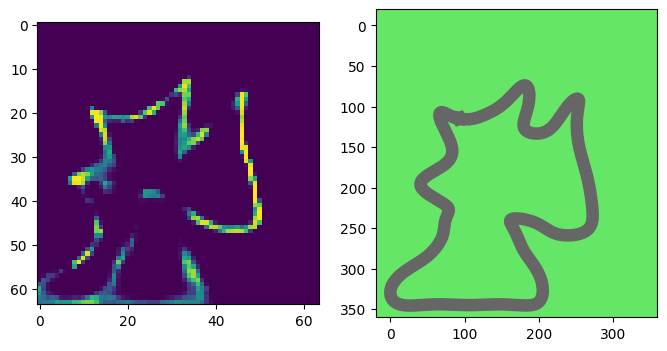

In [59]:
# Reconstruct image from latent space vector
noise = torch.randn(1, 24).to(device)
recon_x = vae.decode(noise).to('cpu').detach().numpy().squeeze()
#Get control points from image
recon_x = (recon_x*255).astype(np.uint8)
control_points = get_control_points_from_image(recon_x)
x, y = control_points[:,0], control_points[:,1]

# Plot track & image
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(recon_x)

plt.subplot(122)
plot_track(np.array([x, y]).T)
plt.gca().invert_yaxis()

(350.0, 0.0)

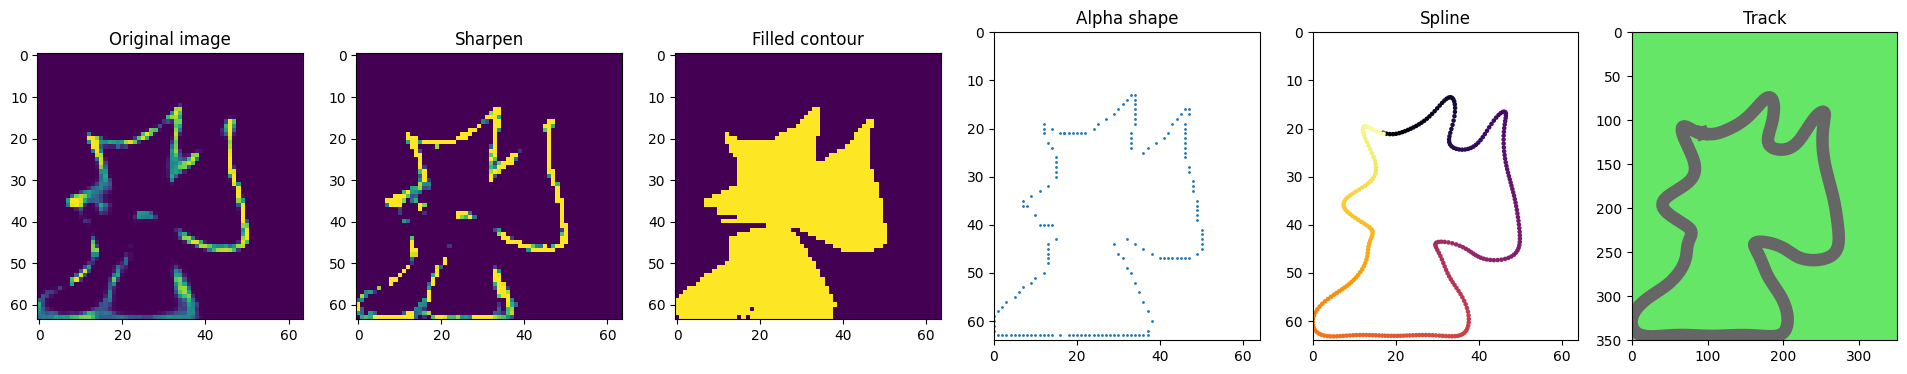

In [60]:
img = recon_x

# Sharpen image
kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
img = cv2.filter2D(img, -1, kernel)
img = np.where(img < 30, 0, img)
img_sharpen = img.copy()

y, x = np.where(img != 0)
# Calculate center
center = [int(x.mean()), int(y.mean())]
points_2d = np.array([x,y]).T
# Fill contour
for point in points_2d:
    cv2.line(img, point, center, color=255, thickness=1)
points_2d = np.array(np.where(img > 100)).T
# Get alpha shape
alpha_shape = alphashape.alphashape(points_2d, alpha=0.6)
geom_type = alpha_shape.geom_type
alpha = 0.6
while geom_type == "MultiPolygon":
    alpha -= 0.01
    alpha_shape = alphashape.alphashape(points_2d, alpha=alpha)
    geom_type = alpha_shape.geom_type

points_alpha_shape = np.array([xy for xy in alpha_shape.exterior.coords])
points = fit_spline(points_alpha_shape, num_points=300)

plt.figure(figsize=(24,4))

plt.subplot(161)
plt.imshow(recon_x)
plt.title("Original image")

plt.subplot(162)
plt.imshow(img_sharpen)
plt.title("Sharpen")

plt.subplot(163)
plt.imshow(img)
plt.title("Filled contour")

plt.subplot(164)
plt.scatter(points_alpha_shape[:,1], points_alpha_shape[:,0], color="tab:blue", s=1)
plt.gca().invert_yaxis()
plt.title("Alpha shape")
plt.xlim(0,64)
plt.ylim(64,0)

plt.subplot(165)
plt.scatter(points[:,1], points[:,0], c=range(len(points)), cmap="inferno", s=5)
plt.gca().invert_yaxis()
plt.title("Spline")
plt.xlim(0,64)
plt.ylim(64,0)

plt.subplot(166)
plot_track(points*350/64)
plt.gca().invert_yaxis()
plt.title("Track")
plt.xlim(0,350)
plt.ylim(350,0)

Reconstruct real tracks from dataset

In [23]:
# Random index
j = np.random.randint(0, X.shape[0])
# Get data
img_orig = dataset[j][0].unsqueeze(0).to(device)
# Reconstruct image using VAE
recon_x, _, _ = vae(img_orig)
recon_x = recon_x.to('cpu').detach().numpy().squeeze()
# Get control points from image
recon_x = (recon_x*255).astype(np.uint8)

Text(0.5, 1.0, 'Track')

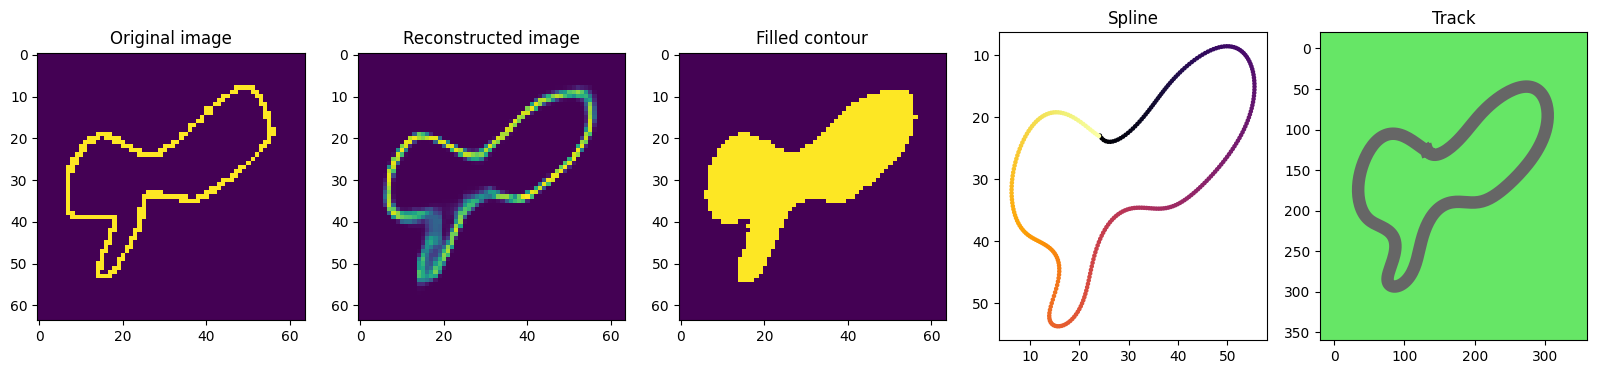

In [24]:
img = recon_x

# Sharpen image
kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
img = cv2.filter2D(img, -1, kernel)
img = np.where(img < 30, 0, img)

import alphashape
y, x = np.where(img != 0)
# Calculate center
center = [int(x.mean()), int(y.mean())]
points_2d = np.array([x,y]).T
# Fill contour
for point in points_2d:
    cv2.line(img, point, center, color=255, thickness=1)
points_2d = np.array(np.where(img > 100)).T
# Get alpha shape
alpha_shape = alphashape.alphashape(points_2d, alpha=0.6)
geom_type = alpha_shape.geom_type
alpha = 0.6
while geom_type == "MultiPolygon":
    alpha -= 0.01
    alpha_shape = alphashape.alphashape(points_2d, alpha=alpha)
    geom_type = alpha_shape.geom_type

points = np.array([xy for xy in alpha_shape.exterior.coords])
points = fit_spline(points, num_points=300)

plt.figure(figsize=(20,4))

plt.subplot(151)
plt.imshow(img_orig.cpu().squeeze())
plt.title("Original image")

plt.subplot(152)
plt.imshow(recon_x)
plt.title("Reconstructed image")

plt.subplot(153)
plt.imshow(img)
plt.title("Filled contour")

plt.subplot(154)
plt.scatter(points[:,1], points[:,0], c=range(len(points)), cmap="inferno", s=5)
plt.gca().invert_yaxis()
plt.title("Spline")

plt.subplot(155)
plot_track(points*350/64)
plt.gca().invert_yaxis()
plt.title("Track")

In [35]:
np.array([x,y]).T

array([[208.03736625, 109.56185101],
       [211.2571723 , 107.12833776],
       [214.87747172, 105.40117113],
       [218.7756275 , 104.18080982],
       [222.85082112, 103.30261144],
       [227.02226913, 102.63393734],
       [231.2274397 , 102.07125751],
       [235.42026918, 101.53725547],
       [239.56937863, 100.97793314],
       [243.65629042, 100.35971572],
       [247.67364476,  99.66655659],
       [251.62341624,  98.89704217],
       [255.51513045,  98.06149683],
       [259.36408046,  97.17908773],
       [263.18954343,  96.27492974],
       [267.01299714,  95.37719032],
       [270.85633655,  94.51419437],
       [274.7400904 ,  93.71152916],
       [278.68163767,  92.98914916],
       [282.69344598,  92.35852951],
       [286.78177365,  91.82085497],
       [290.94640935,  91.36752565],
       [295.18077149,  90.98146565],
       [299.47201874,  90.63845679],
       [303.80116057,  90.30847237],
       [308.14316779,  89.95701086],
       [312.46708312,  89.54642963],
 

___________

In [1044]:
# Generate random control points
control_points = np.random.rand(12,2)
# Map to [0,350]
control_points *= 350

_, x, y = get_track(control_points=control_points)

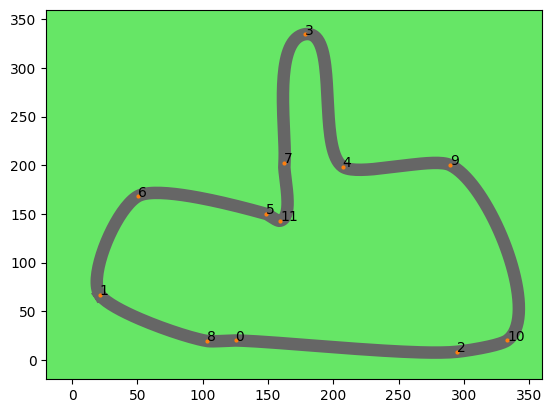

In [1045]:
plot_track(np.array([x, y]).T, control_points)

___________

Visualize latent space

In [30]:
# Load VAE model
vae = VAE(z_dim=24).to(device) # GPU
vae.load_state_dict(torch.load("vae_64x64_24.pt"))

<All keys matched successfully>

In [1116]:
# Get data

# Reconstruct image using VAE
recon_x, _, _ = vae(img_orig)
recon_x = recon_x.to('cpu').detach().numpy().squeeze()

In [1135]:
x.shape

torch.Size([1, 1, 64, 64])

In [1147]:
encoded_data = []

for j in range(len(dataset)):
    x = dataset[j][0].unsqueeze(0).to(device)
    z, _, _ = vae.encode(x)
    encoded_data.append(z)
    print(f"Progress: {j} out of {len(dataset)}", end="\r")

encoded_data = np.array([z.cpu().detach().numpy() for z in encoded_data])
encoded_data = encoded_data[:,0,:]

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 4.00 GiB total capacity; 9.66 GiB already allocated; 0 bytes free; 9.79 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1163]:
# tSNE
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(encoded_data)

In [1164]:
X_embedded.shape

(48223, 2)

In [30]:
i = np.random.randint(0, X_embedded.shape[0]-1)
j = np.random.randint(0, X_embedded.shape[0]-1)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(X[i])
plt.title(i)
plt.subplot(122)
plt.imshow(X[j])
plt.title(j)

NameError: name 'X_embedded' is not defined

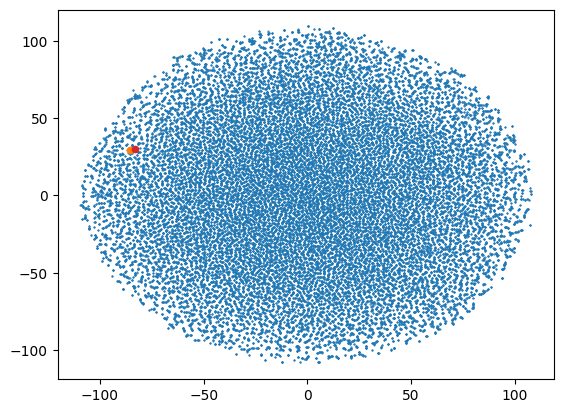

In [1198]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=0.2)

plt.scatter(X_embedded[i,0], X_embedded[i,1], s=20, color="tab:orange")
plt.scatter(X_embedded[j,0], X_embedded[j,1], s=20, color="tab:red")

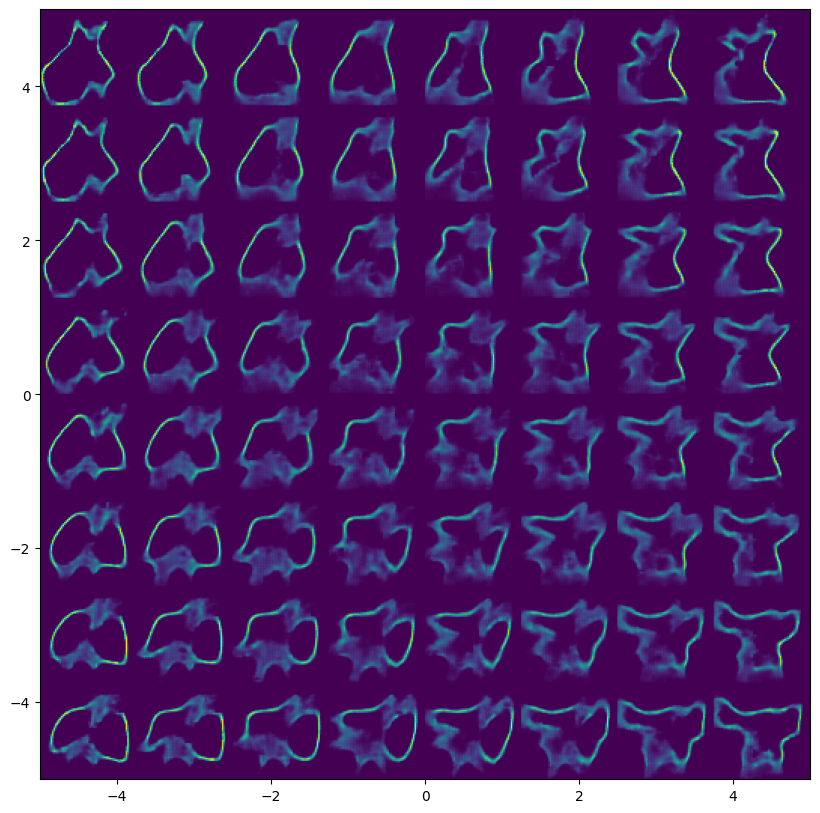

In [29]:
# Generate zeros vector
z = torch.zeros(1, 16).to(device)

n = 8  # Number of points

r0 = (-5, 5)
r1 = (-5, 5)

c1 = 1  # Element to vary
c2 = 14

w = 64
img = np.zeros((n*w, n*w))

plt.figure(figsize=(10,10))
# Variate the first element of the vector from -3 to 3
for i, x in enumerate(np.linspace(*r0, n)):
    for j, y in enumerate(np.linspace(*r1, n)):
        z[0,c1] = x
        z[0,c2] = y
        # Reconstruct image using VAE
        recon_x = vae.decode(z).to('cpu').detach().numpy().squeeze()
        img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = recon_x
plt.imshow(img, extent=[*r0, *r1])